<a href="https://colab.research.google.com/github/vasighiz/bio-dl-test/blob/main/bio_dl_test_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Part 1: Scanpy-based scRNA-seq Analysis

In [ ]:
pip install scanpy --quiet

In [ ]:
pip install igraph --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.0 MB/s eta 0:00:00


In [ ]:
pip install leidenalg --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.4 MB/s eta 0:00:00


In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
adata = sc.datasets.pbmc3k()
adata = adata[:300]  # Subsample for speed

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

In [ ]:
# Preprocessing
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:170: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


In [ ]:
# PCA, neighbors, UMAP
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


<ipython-input-18-4c8716ee354e>:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


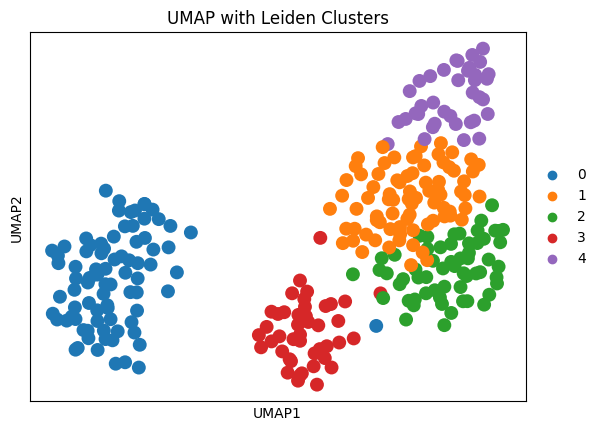

In [ ]:
# Clustering
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'], title='UMAP with Leiden Clusters')

/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


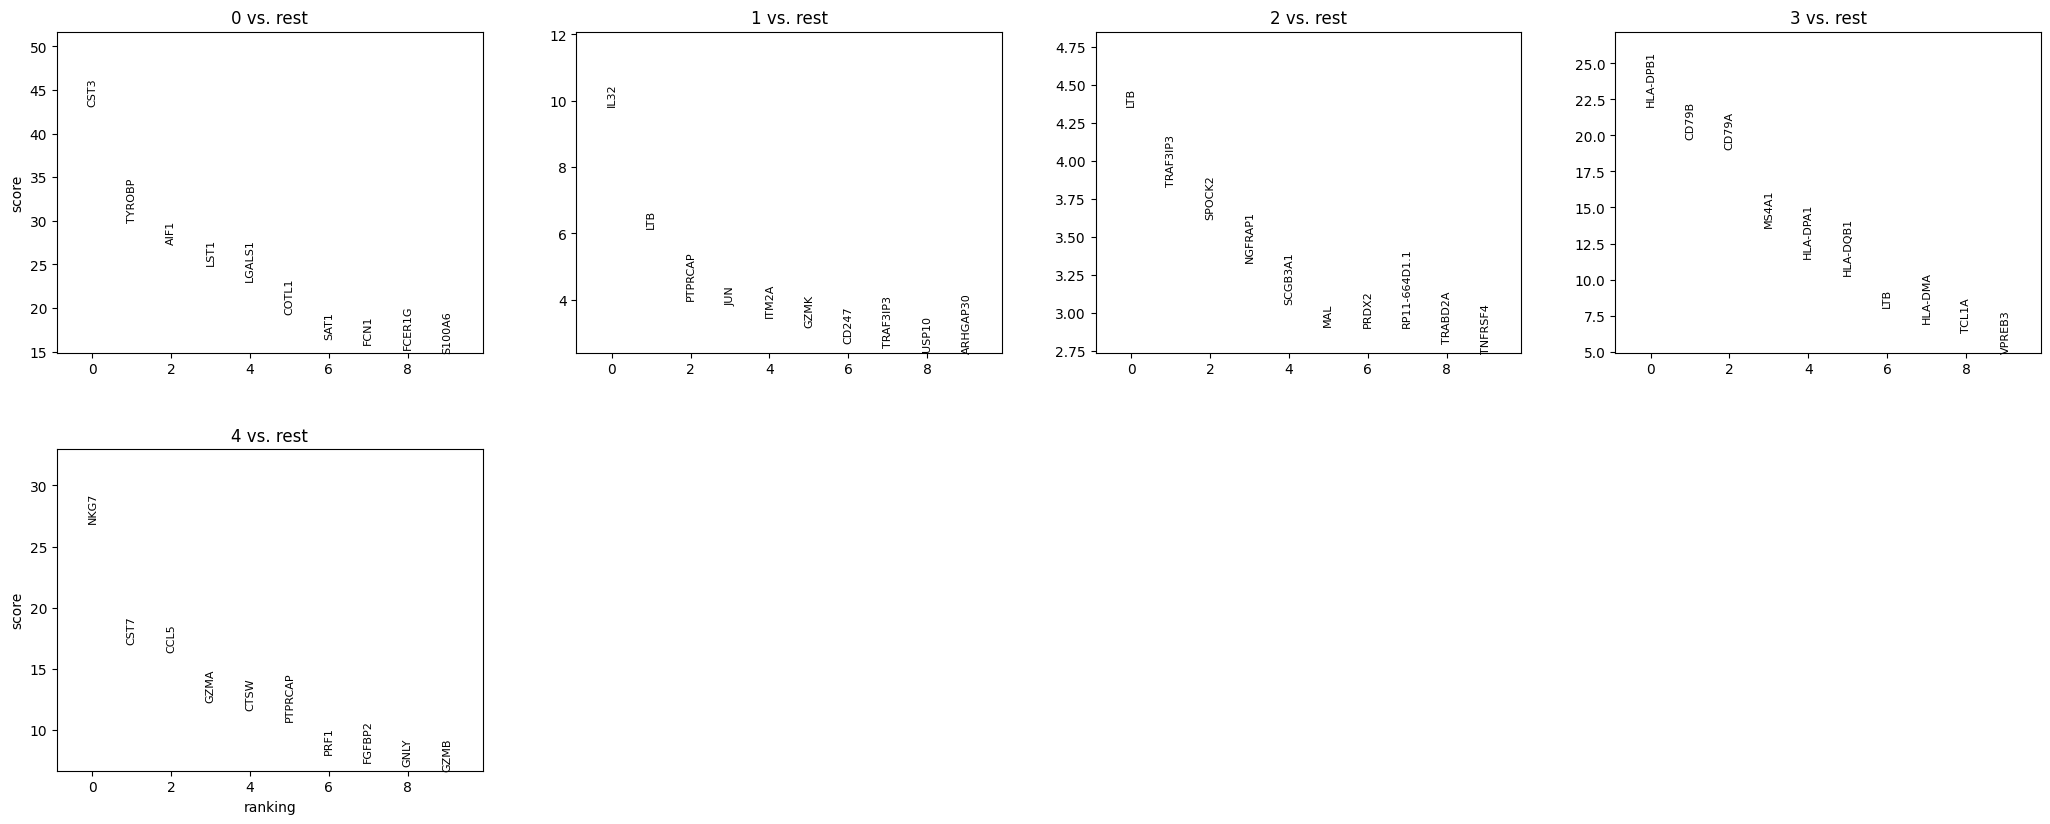

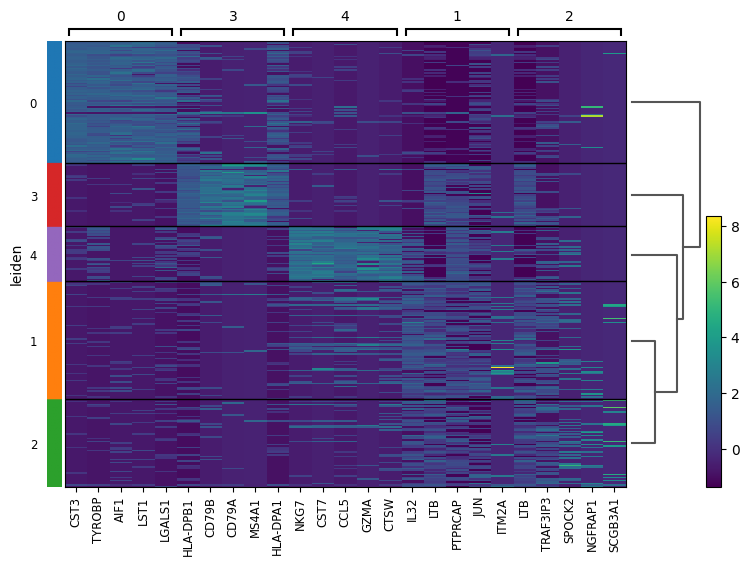

In [ ]:
# Marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='leiden', show=True)

**Interpretation:** The clusters represent different immune cell types in PBMCs. The UMAP plot shows clear separations, and marker gene heatmap provides top markers per cluster.

## Part 2a: Deep Learning - PyTorch Autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

In [ ]:
# Prepare data
X = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

In [ ]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 64), nn.ReLU(), nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 64), nn.ReLU(), nn.Linear(64, input_dim))
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

model = Autoencoder(X_tensor.shape[1], 10)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [ ]:
# Train
for epoch in range(100):
    optimizer.zero_grad()
    out, _ = model(X_tensor)
    loss = loss_fn(out, X_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.0137
Epoch 20, Loss: 0.9822
Epoch 40, Loss: 0.9364
Epoch 60, Loss: 0.8887
Epoch 80, Loss: 0.8448


In [ ]:
# Extract latent space
_, latent = model(X_tensor)
latent_np = latent.detach().numpy()

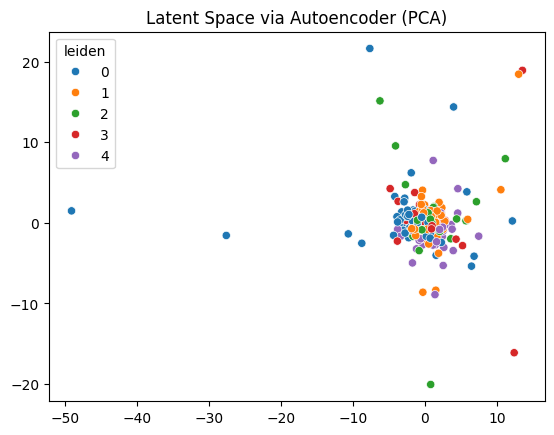

In [ ]:
# Visualize
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_np)
sns.scatterplot(x=latent_pca[:, 0], y=latent_pca[:, 1], hue=adata.obs['leiden'], palette='tab10')
plt.title("Latent Space via Autoencoder (PCA)")
plt.show()

##  Part 2b: Deep Learning - scVI Variational Autoencoder

In [ ]:
# First: ensure no old versions remain
!pip uninstall -y scvi scvi-tools

# Then: install the correct one
!pip install --quiet scvi-tools

Found existing installation: scvi-tools 1.3.0
Uninstalling scvi-tools-1.3.0:
  Successfully uninstalled scvi-tools-1.3.0


In [ ]:
import scvi
from scvi.model import SCVI

/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [ ]:
# Setup scvi model
adata_scvi = adata.raw.to_adata() if adata.raw else adata.copy()
scvi.model.SCVI.setup_anndata(adata_scvi)
vae = scvi.model.SCVI(adata_scvi)
vae.train(max_epochs=50)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
# Extract latent representation (use correct method)
adata.obsm["X_scVI"] = vae.get_latent_representation()

<ipython-input-20-7f8aa1ebe3d2>:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


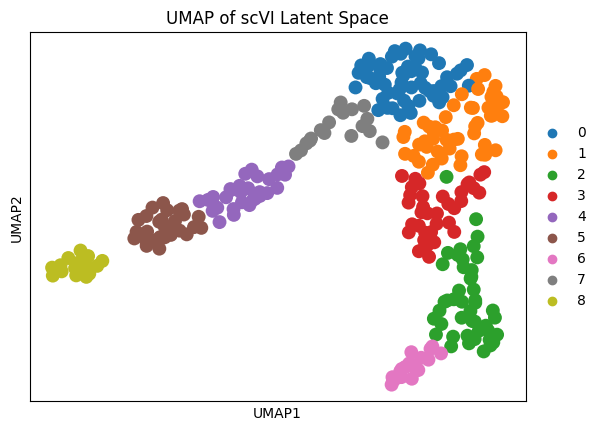

In [ ]:
# Use scVI latent space for clustering and UMAP
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="leiden", title="UMAP of scVI Latent Space")

##  Part 3: Multi-Omics Integration

**Two Strategies for Integration:**
1. Early Integration (Concatenation): Combine features before model input.
2. Late Integration (Ensemble): Separate models for each omic type, combine outputs.

**Minimal Code for Concatenation:**
```python
rna = adata.layers['rna']
protein = adata.obsm['protein']
combined = np.concatenate([rna, protein], axis=1)
```

##  Part 4: Scientific Reasoning

**3 Possible Causes of Poor Clustering:**
1. Inadequate normalization or preprocessing
2. Too few PCs or wrong neighborhood parameters
3. Biologically similar cells genuinely hard to distinguish

**2 Suggestions:**
- Increase resolution or try alternative clustering
- Use more robust latent space (e.g., scVI or Harmony)

**Abstract:**
We performed a comprehensive analysis of PBMC single-cell transcriptomic data using Scanpy and deep learning approaches. Our preprocessing and clustering pipeline revealed distinct immune cell populations. An autoencoder and scVI model were trained to reduce dimensionality and capture meaningful latent representations. Integration strategies and biological interpretation were explored, highlighting the value of generative AI in single-cell omics.